In [1]:
%pylab notebook
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_parameters():
    '''
    Define simulation, stimulus and neuron parameters and stores values in parameter dictionary p.

    Returns:
    --------
    p : dict
        Parameter dictionary.
      
    '''
    ## store parameters in dictionary
    p = {}
  
    ## simulation parameters
    p['T'] = 50.                ## simulation time (ms)
    p['dt'] = 0.025              ## simulation time resolution (ms)

    ## stimulus parameters
    p['I_amp'] = -10.           ## input current amplitude (uA/cm2)
    p['t_stim_on'] = 5.            ## stimulus-on time (ms)
    p['t_stim_off'] = 30           ## stimulus-off time (ms)

    ## neuron parameters
    p['V_rest'] = -65.             ## resting potential (mV)
    p['Cm'] = 1.               ## membrane capacitance (uF/cm2)
    p['gbar_Na'] = 120.             ## max. Na conductance (mS/cm2)
    p['gbar_K'] = 36.               ## max K conductance (mS/cm2)
    p['gbar_l'] = 0.3              ## leak conductance (mS/cm2)
    p['E_Na'] = 50.              ## Na reversal potentail (mV)
    p['E_K'] = -77.             ## K reversal potentail (mV)
    p['E_l'] = -54.387          ## Leak reversal potentail (mV)

    ## voltage dependence of gate variables    
    ### K activation
    p['alpha_n'] = np.vectorize(lambda v: 0.01*(v+55.) / (1.-np.exp(-(v + 55.)/10.)) 
                                if v != -55. else 0.1) ## activation rate (1/ms)
    p['beta_n'] = lambda v: 0.125*np.exp(-(v+65.)/80.) ## inactivation rate (1/ms)
    
    ### Na activation
    p['alpha_m'] = np.vectorize(lambda v: 0.1*(v + 40.)/(1.-np.exp(-(v + 40.)/10.)) 
                                if v != -40. else 1)  ## activation rate (1/ms)
    p['beta_m'] = lambda v: 4.*np.exp(-(v+65.)/18.)   ## inactivation rate (1/ms)
    
    ### Na inactivation
    p['alpha_h'] = lambda v: 0.07*np.exp(-(v+65.)/20.)  ## activation rate (1/ms)
    p['beta_h'] = lambda v: 1./(1.+np.exp(-(v + 35.)/10.)) ## inactivation rate (1/ms)

    derived_parameters(p)  ## add derived parameters to dictionary (see below)

    ## HINT: Storing parameters in dictionaries simplifies function definitions by 
    ## reducing number of arguments (see below).
    
    return p

In [3]:
def derived_parameters(p):
    '''
    Set derived parameters, i.e. parameters which are fully defined by parameters in p.

    Parameters:
    -----------
    p: dict
       Parameter dictionary
     
    Returns:
    --------
    nothing (p is modified "on-the-fly").
    
    '''
    
    p['time'] = np.arange(0, p['T']+p['dt'], p['dt'])                          ## time array (ms)
    p['n_inf'] = lambda v: p['alpha_n'](v)/(p['alpha_n'](v) + p['beta_n'](v)) ## steady-state K activation
    p['tau_n'] = lambda v: 1./(p['alpha_n'](v) + p['beta_n'](v))              ## (ms)
    p['m_inf'] = lambda v: p['alpha_m'](v)/(p['alpha_m'](v) + p['beta_m'](v)) ## steady-state Na activation
    p['tau_m'] = lambda v: 1./(p['alpha_m'](v) + p['beta_m'](v))              ## (ms)
    p['h_inf'] = lambda v: p['alpha_h'](v)/(p['alpha_h'](v) + p['beta_h'](v)) ## steady-state Na inactivation
    p['tau_h'] = lambda v: 1./(p['alpha_h'](v) + p['beta_h'](v))              ## (ms)

In [4]:
def stimulus(p):
    '''
    Consctructs array I of input currents with

    I(t) = p['I_amp']        for p['t_stim_on'] <= t <= p['t_stim_off']
    I(t) = 0.0               else.

    (i.e. current pulse of length p['t_stim_off']-p['t_stim_on']).
    
    Parameters:
    -----------
    p: dict
       Parameter dictionary
     
    Returns:
    --------
    I: ndarray
       Array of input currents with with len(I)=len(p['time']).

    '''
  
    I = np.zeros(len(p['time']))

    ## step stimulus
    for i, t in enumerate(p['time']):
        if p['t_stim_on'] <= t <= p['t_stim_off']:
            I[i] = p['I_amp']

    return I

In [5]:
def update(Vm, m, h, n, I, p):
    '''
    Updates neuron state (Vm,m,h,n) from time step i-1 to time step i.

    Parameters:
    -----------
    Vm: float
        Membrane potentential at time step i-1.
     m: float
        Na activation at time step i-1.
     h: float
        Na inactivation at time step i-1.
     n: float
        K activation at time step i-1.
     I: float
        Input current at time step i-1.
     p: dict
        Parameter dictionary
    
    Returns:
    --------
    Vm: float
        Membrane potentential at time step i.
     m: float
        Na activation at time step i.
     h: float
        Na inactivation at time step i.    
     n: float
        K activation at time step i.
  
    '''
    
    g_Na = p['gbar_Na']*(m**3)*h
    g_K = p['gbar_K']*(n**4)
    g_l = p['gbar_l']
    m += (p['alpha_m'](Vm)*(1 - m) - p['beta_m'](Vm)*m) * p['dt']
    h += (p['alpha_h'](Vm)*(1 - h) - p['beta_h'](Vm)*h) * p['dt']
    n += (p['alpha_n'](Vm)*(1 - n) - p['beta_n'](Vm)*n) * p['dt']
    Vm += (I - g_Na*(Vm - p['E_Na']) - g_K*(Vm - p['E_K']) - g_l*(Vm - p['E_l'])) / p['Cm'] * p['dt']
    
    return Vm, m, h, n

In [6]:
def simulate(p):
    '''
    1) Initialises state variables Vm, m, h, n with respective values at resting potential p['V_rest'].
    2) Constructs and returns array I of input currents by calling stimulus().
    3) Constructs array Vm of membrane potentials by calling update() in each time step.

    Parameters:
    -----------
    p: dict
       Parameter dictionary
       
    Returns:
    --------
    Vm: ndarray
        Array of membrane potentials with len(Vm)=len(p['time']).
     I: ndarray
        Array of input currents with len(I)=len(p['time']).

    '''
  
    Vm = np.zeros(len(p['time']))  # initialise membrane-potential array (mV)
    ## initial conditions
    Vm[0] = p['V_rest']
    m = p['m_inf'](p['V_rest'])
    h = p['h_inf'](p['V_rest'])
    n = p['n_inf'](p['V_rest'])
  
    I = stimulus(p) ## array of stimulus currents (uA/cm2)
  
    ## loop over time steps
    for i in range(1, len(p['time'])):
        Vm[i], m, h, n = update(Vm[i-1], m, h, n, I[i-1], p)
    return Vm, I

Main simulation:

<IPython.core.display.Javascript object>


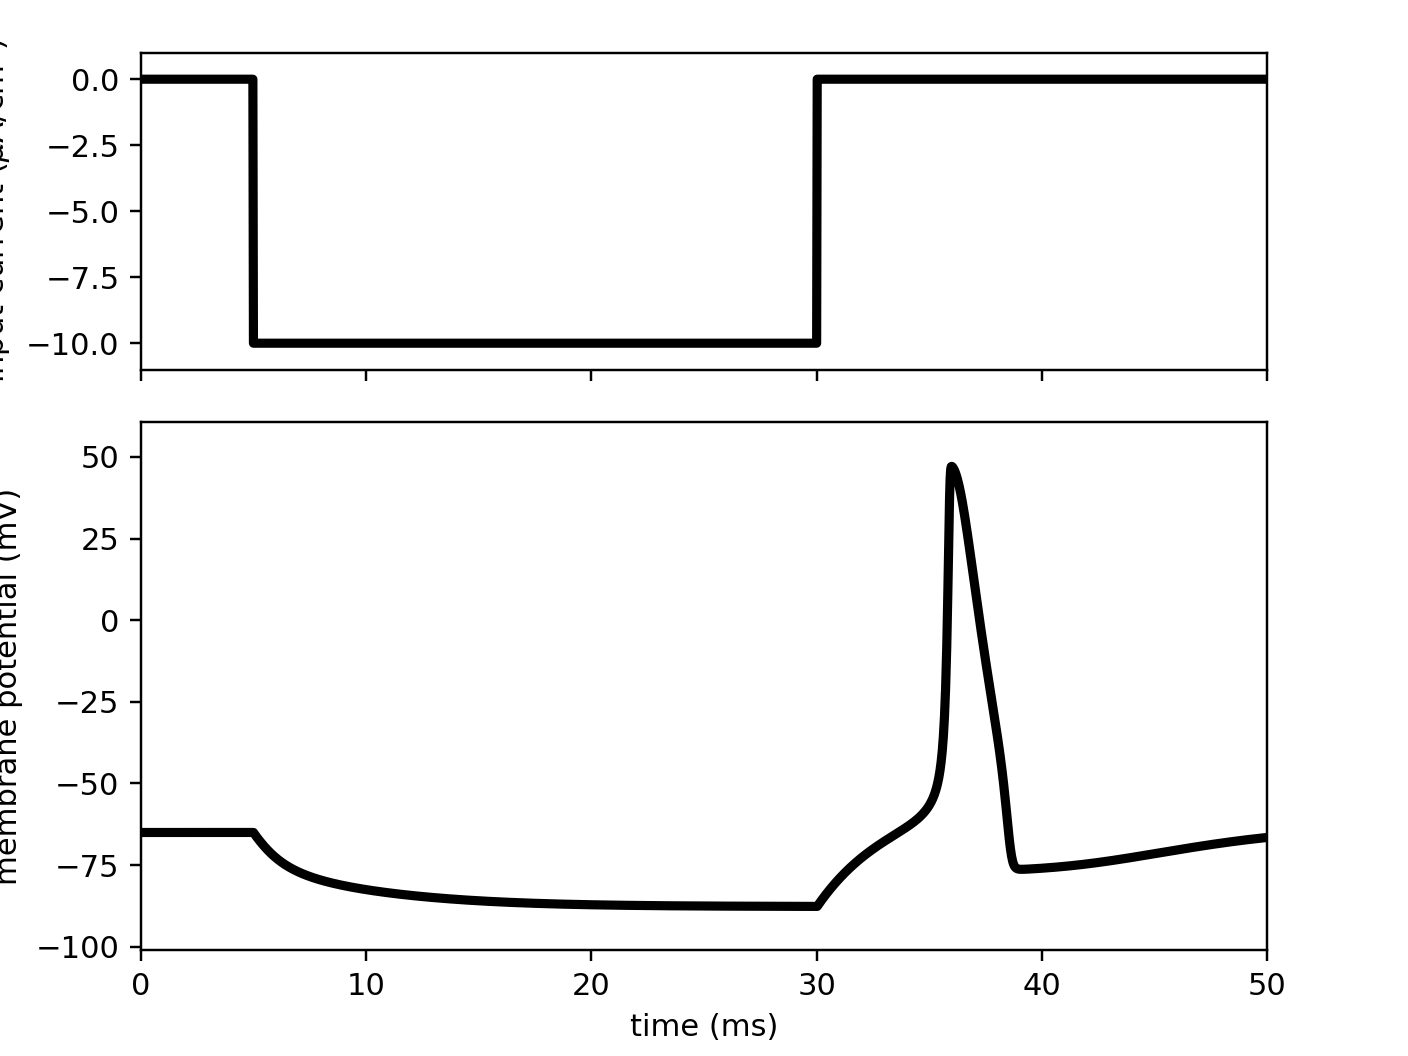

In [7]:
## set parameters
p = set_parameters()

## simulate
Vm, I = simulate(p)

## plot results
figure(1)
clf()

### input current
sp1 = subplot(211)
plot(p['time'], I, 'k-', lw=3)
ylabel('input current ($\mu$A/cm$^2$)')
xlim(p['time'][0], p['time'][-1])
offset = 0.1*np.abs(np.max(I)-np.min(I))
ylim(np.min(I)-offset, np.max(I)+offset)
sp1.set_position([0.1, 0.65, 0.8, 0.3])
setp(gca(), xticklabels=[])

### membrane potential 
sp2 = subplot(212)
plot(p['time'], Vm, 'k-', lw=3)
ylabel('membrane potential (mV)')
xlabel('time (ms)')
xlim(p['time'][0], p['time'][-1])
offset = 0.1*np.abs(np.max(Vm)-np.min(Vm))
ylim(np.min(Vm)-offset, np.max(Vm)+offset)
sp2.set_position([0.1, 0.1, 0.8, 0.5])

savefig('exercise_3_result.png')  ## saves figure as pdf file
